In [1]:
#import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#download provided NFL data
df_games = pd.read_csv('games.csv')
df_player_play = pd.read_csv('player_play.csv')
df_players = pd.read_csv('players.csv')
df_plays = pd.read_csv('plays.csv')
df_w1 = pd.read_csv('tracking_week_1.csv')
df_w2 = pd.read_csv('tracking_week_2.csv')
df_w3 = pd.read_csv('tracking_week_3.csv')
df_w4 = pd.read_csv('tracking_week_4.csv')
df_w5 = pd.read_csv('tracking_week_5.csv')
df_w6 = pd.read_csv('tracking_week_6.csv')
df_w7 = pd.read_csv('tracking_week_7.csv')
df_w8 = pd.read_csv('tracking_week_8.csv')
df_w9 = pd.read_csv('tracking_week_9.csv')

Notes on DataFrames
- shiftSinceLineset (may be useful)
- event (lineset?)

In [4]:
#concatenate the player tracking dataframes
tracking = pd.concat([df_w1,df_w2,df_w3,df_w4,df_w5,df_w6,df_w7,df_w8,df_w9])

In [5]:
#change all plays to going in the same direction
#to save space, also multiply by 100 and convert to int

def standardize_df(df):
    #set all plays go left to right, and convert floats to ints to save memory
    df['x_std'] = np.where(
        df["playDirection"] == "left",
        (120 - df["x"].to_numpy()) * 100,
        df["x"].to_numpy() * 100
    ).astype(int)
    df['y_std'] = np.where(
        df["playDirection"] == "left",
        (120 - df["y"].to_numpy()) * 100,
        df["y"].to_numpy() * 100
    ).astype(int)

    #standardize and clean the 'o' column to go left to right
    df["o_std"] = (-(df["o"] - 90)) % 360
    df["o_std"] = np.where(
        df["playDirection"] == "left",
        (180 - df["o_std"]) % 360,
        df["o_std"]
    )
    df["o_std"] = (df["o_std"] * 100).fillna(0).astype(int)  #scale and convert to int
    
    #standardize and clean the 'dir' column to go left to right
    df["dir_std"] = (-(df["dir"] - 90)) % 360
    df["dir_std"] = np.where(
        df["playDirection"] == "left",
        (180 - df["dir_std"]) % 360, 
        df["dir_std"]
    )
    df["dir_std"] = (df["dir_std"] * 100).fillna(0).astype(int)  #scale and convert to int

    #convert other cells to int
    df['s_std'] = (df['s']*100).astype(int)
    df['a_std'] = (df['a']*100).astype(int)
    df['dis_std'] = (df['dis']*100).astype(int)

    #downcast columns to save memory
    df['x_std'] = pd.to_numeric(df['x_std'], downcast='integer')
    df['y_std'] = pd.to_numeric(df['y_std'], downcast='integer')
    df['o_std'] = pd.to_numeric(df['o_std'], downcast='integer')
    df['dis_std'] = pd.to_numeric(df['dis_std'], downcast='integer')
    df['dir_std'] = pd.to_numeric(df['dir_std'], downcast='integer')
    df['s_std'] = pd.to_numeric(df['s_std'], downcast='integer')
    df['a_std'] = pd.to_numeric(df['a_std'], downcast='integer')


In [6]:
standardize_df(tracking)

In [7]:
#calculate run-dropback percentages in provided data
run_pct = len(df_plays[df_plays['passResult'].isnull()]) / len(df_plays)
dropback_pct = len(df_plays[df_plays['passResult'].notnull()]) / len(df_plays)
print(f"design run: {run_pct:.1%} \ndropback:   {dropback_pct:.1%}")

design run: 39.6% 
dropback:   60.4%


In [8]:
#need to calculate what happens between tracking events 'line_set' and 'ball_snap'

In [9]:
#check if every snap has the events needed

len(tracking[['gameId', 'playId', 'nflId']].drop_duplicates())

370852

In [10]:
tracking['event'].value_counts()

event
ball_snap                    369426
line_set                     367517
huddle_break_offense         292307
first_contact                239844
tackle                       231058
pass_forward                 199157
pass_arrived                 156699
handoff                      132434
pass_outcome_caught          123165
man_in_motion                120750
pass_outcome_incomplete       65251
play_action                   63135
shift                         46690
out_of_bounds                 40548
run                           20953
qb_sack                       12213
touchdown                      9936
dropped_pass                   6969
autoevent_passinterrupted      6647
pass_tipped                    4876
fumble                         4761
pass_outcome_interception      4324
pass_outcome_touchdown         4186
qb_kneel                       3795
play_submit                    3657
fumble_offense_recovered       2898
qb_slide                       2760
fumble_defense_recover

In [11]:
tracking_unique_ids = tracking[['gameId', 'playId', 'nflId']].drop_duplicates()

In [12]:
len(tracking_unique_ids)

370852

In [13]:
lineset_unique_ids = tracking[tracking['event'] == 'line_set'][['gameId', 'playId', 'nflId']].drop_duplicates()

In [14]:
lineset_unique_ids.head()

,gameId,playId,nflId
42,2022091200,64,35459.0
205,2022091200,64,39987.0
368,2022091200,64,41310.0
531,2022091200,64,42393.0
694,2022091200,64,42403.0


In [15]:
df_all = tracking_unique_ids.merge(lineset_unique_ids.drop_duplicates(), on=['gameId','playId','nflId'], 
                   how='left', indicator=True)
df_all = df_all[df_all['_merge'] == 'left_only']

In [16]:
df_all[['gameId','playId']].drop_duplicates()

,gameId,playId
6739,2022091108,2353
6762,2022091108,2377
6854,2022091108,2559
10856,2022091111,665
14973,2022091110,3026
...,...,...
361813,2022110602,2548
362204,2022110602,3064
362457,2022110602,3424
366229,2022110600,1162


In [17]:
tracking[(tracking['gameId'] == 2022091108) & (tracking['playId'] == 2353)].iloc[50:100]

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,o,dir,event,x_std,y_std,o_std,dir_std,s_std,a_std,dis_std
1091216,2022091108,2353,38538.0,Ryan Tannehill,51,BEFORE_SNAP,2022-09-11 22:22:42.1,17.0,TEN,right,...,79.74,83.25,NaN,5342,3012,1026,675,0,0,0
1091217,2022091108,2353,38538.0,Ryan Tannehill,52,BEFORE_SNAP,2022-09-11 22:22:42.2,17.0,TEN,right,...,79.74,76.50,NaN,5342,3012,1026,1350,0,0,0
1091218,2022091108,2353,38538.0,Ryan Tannehill,53,BEFORE_SNAP,2022-09-11 22:22:42.3,17.0,TEN,right,...,78.99,72.59,NaN,5342,3012,1101,1740,0,0,0
1091219,2022091108,2353,38538.0,Ryan Tannehill,54,BEFORE_SNAP,2022-09-11 22:22:42.4,17.0,TEN,right,...,78.99,64.85,NaN,5342,3012,1101,2515,0,0,0
1091220,2022091108,2353,38538.0,Ryan Tannehill,55,BEFORE_SNAP,2022-09-11 22:22:42.5,17.0,TEN,right,...,78.99,55.18,NaN,5342,3012,1101,3482,0,0,0
1091221,2022091108,2353,38538.0,Ryan Tannehill,56,BEFORE_SNAP,2022-09-11 22:22:42.6,17.0,TEN,right,...,79.92,59.46,NaN,5342,3012,1007,3054,0,0,0
1091222,2022091108,2353,38538.0,Ryan Tannehill,57,BEFORE_SNAP,2022-09-11 22:22:42.7,17.0,TEN,right,...,79.92,50.47,NaN,5342,3012,1007,3953,0,0,0
1091223,2022091108,2353,38538.0,Ryan Tannehill,58,BEFORE_SNAP,2022-09-11 22:22:42.8,17.0,TEN,right,...,79.92,62.16,NaN,5342,3012,1007,2784,0,0,0
1091224,2022091108,2353,38538.0,Ryan Tannehill,59,BEFORE_SNAP,2022-09-11 22:22:42.9,17.0,TEN,right,...,79.92,71.35,NaN,5342,3012,1007,1865,0,0,0
1091225,2022091108,2353,38538.0,Ryan Tannehill,60,BEFORE_SNAP,2022-09-11 22:22:43,17.0,TEN,right,...,79.92,66.11,NaN,5342,3012,1007,2389,0,0,0


In [18]:
#start with plays that have lineset noted (may need to estimate lineset later for other plays)

#get coordinate values at lineset and ball_snap


tracking_line_set = tracking[tracking['event'] == 'line_set'].drop(columns=['jerseyNumber','time','x', 'y', 's', 'a', 'dis', 'o', 'dir','playDirection'])
tracking_ball_snap = tracking[tracking['event'] == 'ball_snap'].drop(columns=['jerseyNumber','time','x', 'y', 's', 'a', 'dis', 'o', 'dir','playDirection'])
                                                

In [19]:
tracking_line_set.head()

,gameId,playId,nflId,displayName,frameId,frameType,club,event,x_std,y_std,o_std,dir_std,s_std,a_std,dis_std
42,2022091200,64,35459.0,Kareem Jackson,43,BEFORE_SNAP,DEN,line_set,5188,2907,18819,14662,34,26,3
205,2022091200,64,39987.0,Geno Smith,43,BEFORE_SNAP,SEA,line_set,3620,2401,207,1009,113,1,11
368,2022091200,64,41310.0,Gabe Jackson,43,BEFORE_SNAP,SEA,line_set,3844,2256,3299,13794,12,48,1
531,2022091200,64,42393.0,Ronald Darby,43,BEFORE_SNAP,DEN,line_set,4584,1400,11798,31952,91,52,9
694,2022091200,64,42403.0,Randy Gregory,43,BEFORE_SNAP,DEN,line_set,4059,1837,16306,18558,28,95,3


In [20]:
tracking_line_to_snap = tracking_line_set.merge(tracking_ball_snap, on=['gameId','playId','nflId','displayName','club'],how='left',suffixes=('_ls','_bs'))

In [21]:
tracking_line_to_snap.head()

,gameId,playId,nflId,displayName,frameId_ls,frameType_ls,club,event_ls,x_std_ls,y_std_ls,...,frameId_bs,frameType_bs,event_bs,x_std_bs,y_std_bs,o_std_bs,dir_std_bs,s_std_bs,a_std_bs,dis_std_bs
0,2022091200,64,35459.0,Kareem Jackson,43,BEFORE_SNAP,DEN,line_set,5188,2907,...,114.0,SNAP,ball_snap,5029.0,2943.0,20994.0,31684.0,112.0,162.0,11.0
1,2022091200,64,39987.0,Geno Smith,43,BEFORE_SNAP,SEA,line_set,3620,2401,...,114.0,SNAP,ball_snap,3794.0,2386.0,1032.0,23178.0,89.0,179.0,8.0
2,2022091200,64,41310.0,Gabe Jackson,43,BEFORE_SNAP,SEA,line_set,3844,2256,...,114.0,SNAP,ball_snap,3852.0,2221.0,31552.0,25251.0,88.0,133.0,9.0
3,2022091200,64,42393.0,Ronald Darby,43,BEFORE_SNAP,DEN,line_set,4584,1400,...,114.0,SNAP,ball_snap,4739.0,1341.0,16580.0,34603.0,25.0,57.0,2.0
4,2022091200,64,42403.0,Randy Gregory,43,BEFORE_SNAP,DEN,line_set,4059,1837,...,114.0,SNAP,ball_snap,4050.0,1763.0,17857.0,20327.0,50.0,71.0,7.0


In [23]:
#total change in coordinates from line set to ball snap
tracking_line_to_snap['x_change'] = abs(tracking_line_to_snap['x_std_ls'] - tracking_line_to_snap['x_std_bs'])
tracking_line_to_snap['y_change'] = abs(tracking_line_to_snap['y_std_ls'] - tracking_line_to_snap['y_std_bs'])

In [24]:
tracking_line_to_snap.head()

,gameId,playId,nflId,displayName,frameId_ls,frameType_ls,club,event_ls,x_std_ls,y_std_ls,...,event_bs,x_std_bs,y_std_bs,o_std_bs,dir_std_bs,s_std_bs,a_std_bs,dis_std_bs,x_change,y_change
0,2022091200,64,35459.0,Kareem Jackson,43,BEFORE_SNAP,DEN,line_set,5188,2907,...,ball_snap,5029.0,2943.0,20994.0,31684.0,112.0,162.0,11.0,159.0,36.0
1,2022091200,64,39987.0,Geno Smith,43,BEFORE_SNAP,SEA,line_set,3620,2401,...,ball_snap,3794.0,2386.0,1032.0,23178.0,89.0,179.0,8.0,174.0,15.0
2,2022091200,64,41310.0,Gabe Jackson,43,BEFORE_SNAP,SEA,line_set,3844,2256,...,ball_snap,3852.0,2221.0,31552.0,25251.0,88.0,133.0,9.0,8.0,35.0
3,2022091200,64,42393.0,Ronald Darby,43,BEFORE_SNAP,DEN,line_set,4584,1400,...,ball_snap,4739.0,1341.0,16580.0,34603.0,25.0,57.0,2.0,155.0,59.0
4,2022091200,64,42403.0,Randy Gregory,43,BEFORE_SNAP,DEN,line_set,4059,1837,...,ball_snap,4050.0,1763.0,17857.0,20327.0,50.0,71.0,7.0,9.0,74.0


<Axes: xlabel='x_change', ylabel='Count'>

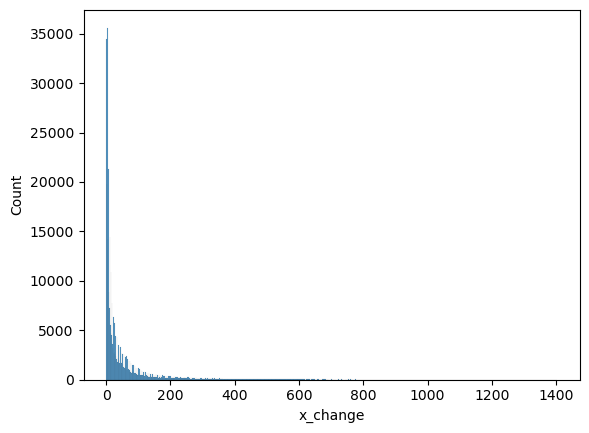

In [27]:
sns.histplot(tracking_line_to_snap['x_change'])

In [28]:
#check what players were in motion (can also check shiftSinceLineset later)
df_player_play_motion_ids = df_player_play[df_player_play['motionSinceLineset'] == True][['gameId','playId','nflId']]
#df_player_play_motion_playIds = df_player_play[df_player_play['motionSinceLineset'] == True][['gameId','playId']].drop_duplicates()

In [29]:
df_player_play_motion_ids.head()

,gameId,playId,nflId
2,2022090800,56,42489
28,2022090800,80,47857
53,2022090800,101,53079
119,2022090800,191,53079
138,2022090800,212,47879


In [30]:
tracking_motion = tracking.merge(df_player_play_motion_ids, on = ['gameId','playId','nflId'], how = 'inner')

In [31]:
#tracking_motion_all = tracking.merge(df_player_play_motion_playIds, on = ['gameId','playId'], how = 'inner')

In [32]:
# # Step 1: Perform a left merge to check for matching rows
# merged = tracking_line_to_snap.merge(
#     df_player_play_motion_ids[['gameId', 'playId', 'nflId']],
#     on=['gameId', 'playId', 'nflId'],
#     how='left',
#     indicator=True
# )

# #designate a column for if the player was in motion or not
# tracking_line_to_snap['in_motion'] = (merged['_merge'] == 'both').astype(int)


In [33]:
# tracking_line_to_snap_motion = tracking_line_to_snap[tracking_line_to_snap['in_motion'] == 1]

In [34]:
# tracking_line_to_snap_motion.head()

things to check
- distance from ball start to finish
- net x,y distance
- Time moving before snap
- But first polish before sending out to Mark and Will

In [36]:
tracking_motion.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,o,dir,event,x_std,y_std,o_std,dir_std,s_std,a_std,dis_std
0,2022091200,64,46189.0,Will Dissly,1,BEFORE_SNAP,2022-09-13 00:16:03.5,89.0,SEA,right,...,209.37,81.95,huddle_break_offense,3397,2545,24063,804,44,50,5
1,2022091200,64,46189.0,Will Dissly,2,BEFORE_SNAP,2022-09-13 00:16:03.6,89.0,SEA,right,...,209.37,90.06,NaN,3401,2545,24063,35994,41,46,4
2,2022091200,64,46189.0,Will Dissly,3,BEFORE_SNAP,2022-09-13 00:16:03.7,89.0,SEA,right,...,205.31,96.17,NaN,3404,2545,24469,35383,37,43,4
3,2022091200,64,46189.0,Will Dissly,4,BEFORE_SNAP,2022-09-13 00:16:03.8,89.0,SEA,right,...,203.06,103.00,NaN,3408,2545,24694,34700,34,47,4
4,2022091200,64,46189.0,Will Dissly,5,BEFORE_SNAP,2022-09-13 00:16:03.9,89.0,SEA,right,...,200.05,115.06,NaN,3411,2544,24995,33494,28,61,3


In [37]:
# tracking_football[''] = (
#     df.groupby(['col1', 'col2', 'col3'])['value']
#     .diff()
# )

In [38]:
#make column of football's position for every step
#then find difference

tracking_motion.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,o,dir,event,x_std,y_std,o_std,dir_std,s_std,a_std,dis_std
0,2022091200,64,46189.0,Will Dissly,1,BEFORE_SNAP,2022-09-13 00:16:03.5,89.0,SEA,right,...,209.37,81.95,huddle_break_offense,3397,2545,24063,804,44,50,5
1,2022091200,64,46189.0,Will Dissly,2,BEFORE_SNAP,2022-09-13 00:16:03.6,89.0,SEA,right,...,209.37,90.06,NaN,3401,2545,24063,35994,41,46,4
2,2022091200,64,46189.0,Will Dissly,3,BEFORE_SNAP,2022-09-13 00:16:03.7,89.0,SEA,right,...,205.31,96.17,NaN,3404,2545,24469,35383,37,43,4
3,2022091200,64,46189.0,Will Dissly,4,BEFORE_SNAP,2022-09-13 00:16:03.8,89.0,SEA,right,...,203.06,103.00,NaN,3408,2545,24694,34700,34,47,4
4,2022091200,64,46189.0,Will Dissly,5,BEFORE_SNAP,2022-09-13 00:16:03.9,89.0,SEA,right,...,200.05,115.06,NaN,3411,2544,24995,33494,28,61,3


In [43]:
#calculate distance from player to football
tracking_football = tracking[tracking['displayName'] == 'football'][['gameId','playId','frameId','x_std','y_std']]

tracking_motion = tracking_motion.merge(tracking_football, on = ['gameId','playId','frameId'], suffixes=('','_fb'))

tracking_motion['dis_fb_x'] = tracking_motion['x_std'] - tracking_motion['x_std_fb']
tracking_motion['dis_fb_y'] = tracking_motion['y_std'] - tracking_motion['y_std_fb']

In [45]:
tracking_motion.head()

,gameId,playId,nflId,displayName,frameId,frameType,time,jerseyNumber,club,playDirection,...,y_std,o_std,dir_std,s_std,a_std,dis_std,x_std_fb,y_std_fb,dis_fb_x,dis_fb_y
0,2022091200,64,46189.0,Will Dissly,1,BEFORE_SNAP,2022-09-13 00:16:03.5,89.0,SEA,right,...,2545,24063,804,44,50,5,3947,2387,550,158
1,2022091200,64,46189.0,Will Dissly,2,BEFORE_SNAP,2022-09-13 00:16:03.6,89.0,SEA,right,...,2545,24063,35994,41,46,4,3947,2387,546,158
2,2022091200,64,46189.0,Will Dissly,3,BEFORE_SNAP,2022-09-13 00:16:03.7,89.0,SEA,right,...,2545,24469,35383,37,43,4,3947,2387,543,158
3,2022091200,64,46189.0,Will Dissly,4,BEFORE_SNAP,2022-09-13 00:16:03.8,89.0,SEA,right,...,2545,24694,34700,34,47,4,3947,2387,539,158
4,2022091200,64,46189.0,Will Dissly,5,BEFORE_SNAP,2022-09-13 00:16:03.9,89.0,SEA,right,...,2544,24995,33494,28,61,3,3947,2387,536,157
